# COVID19 vaccine mRNA Degradation 

Dataset (sourced from https://www.kaggle.com/c/stanford-covid-vaccine and consisted of
2400 mRNA samples. 
Each mRNA is of 107 nucleotides and measurements (reactivity and degradation) are performed on frist 68 ntds.  
Measurements: reactivity (higher the reactivity more degradation), degradation at pH10 with and without Mg2+, and degradation at $50°C with and without Mg2+.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import feyn
from sklearn.model_selection import train_test_split

from IPython.display import display

This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/eula`.


## Load Dataset

In [2]:
data = pd.read_json('covid_mrna.json', lines=True)
data = data.drop('index', axis=1)

# FILTER THE DATA SET
##Remove row with SN_filter == 0 (signal to noise filter)
##Remove row with RNAs that are all "." for the first 68 bases

In [3]:
data.query('SN_filter == 1', inplace=True)

length = len(data.iloc[0]['reactivity'])
first_68 = data['structure'].apply(lambda x : x[0: length])


idx_all_dots = [i for i in first_68.index if first_68[i].count('.') == length]
data = data.drop(idx_all_dots)

In [4]:
data.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


PREPERATION OF SEQUENCES FOR THE QLATTICE

In [6]:
end_pos = len(data.loc[0, 'predicted_loop_type'])

RNA_idx = [j for j in data.index for i in range(0, end_pos)]
pos_idx = [i for j in data.index for i in range(0, end_pos)]

loop_exp = data['predicted_loop_type'].apply(lambda x : list(x)).agg(sum)
base_exp = data['sequence'].apply(lambda x : list(x)).agg(sum)

exp_df = pd.DataFrame({'loop' : loop_exp, 'base': base_exp, 'RNA_idx' : RNA_idx, 'pos_idx' : pos_idx})

In [7]:
react_len = len(data.iloc[0].reactivity)

In [8]:
df = exp_df[exp_df.pos_idx < react_len]
df = df[df.pos_idx >= 5]

df['reactivity'] = df.apply(lambda row: data.loc[row.RNA_idx].reactivity[row.pos_idx], axis=1)

df['sequence'] = data.loc[df.RNA_idx].set_index(df.index).sequence
df['base_left_motif'] = df.apply(lambda x: x['sequence'][:x.pos_idx][-2:], axis=1)
df['base_right_motif'] = df.apply(lambda x: x['sequence'][x.pos_idx + 1:][:2], axis=1)

df['loop_type'] = data.loc[df.RNA_idx].set_index(df.index).predicted_loop_type
df['loop_left_motif'] = df.apply(lambda x: x['loop_type'][:x.pos_idx][-2:], axis=1)
df['loop_right_motif'] = df.apply(lambda x: x['loop_type'][x.pos_idx + 1:][:2], axis=1)

TRAIN
VALIDAT
HOLDOUT 

In [9]:
train_idx, remain_idx = train_test_split(list(data.index),train_size = 0.5, random_state = 42)
valid_idx, holdout_idx = train_test_split(remain_idx,train_size = 0.5, random_state = 42)

train = df.query('RNA_idx == @train_idx')
valid = df.query('RNA_idx == @valid_idx')
holdout = df.query('RNA_idx == @holdout_idx')

In [10]:
train.head()

,loop,base,RNA_idx,pos_idx,reactivity,sequence,base_left_motif,base_right_motif,loop_type,loop_left_motif,loop_right_motif
5,S,A,0,5,0.4384,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,AA,GC,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,EE,SS
6,S,G,0,6,0.2560,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,AA,CU,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,ES,SS
7,S,C,0,7,0.3364,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,AG,UC,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,SS,SS
8,S,U,0,8,0.2168,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,GC,CU,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,SS,SS
9,S,C,0,9,0.3583,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,CU,UA,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,SS,SH


## QLattice TRAINING>>> COMPLEX MODEL

In [11]:
ql = feyn.connect_qlattice()

Deprecation: The connect_qlattice() is deprecated. Use the `feyn.QLattice()` constructor instead.


In [12]:
ql.reset(42)

Deprecation: The reset() function is deprecated. Instantiating a new feyn.QLattice() now achieves the same result.


OUTPUT VARIABLE

In [13]:
output = 'reactivity'

FEATURES

In [14]:
features = ['base', 'loop', 'base_left_motif', 'base_right_motif', 'loop_left_motif', 'loop_right_motif']

CATEGORICAL FEATURES

In [15]:

stypes = {}
for f in features:
    if train[f].dtype =='object':
        stypes[f] = 'c'

BIC SELECTION: BEST MODELS

In [16]:
models = ql.auto_run(train[features+[output]], output, stypes=stypes, criterion='bic')

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="264.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 1011 264.0" width="1011" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="831" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="721" y="50.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=-1.840107
bias=-0.0022</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="766.0" y="71.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="809" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="723" y="59.0">out</text><line stroke="#1E1E1E" x1="691" x2="721" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="601" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="59.0">1</text><line stroke="#1E1E1E" x1="571" x2="601" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="571" x2="601" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="20.0"><title>base_right_motif
categorical with 16 values
bias=0.1611</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="41.5">base_rig..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="29.0">cat</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="80.0"><title>log</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="101.5">log</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="89.0">3</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="97.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">4</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="20.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">5</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>loop_right_motif
categorical with 18 values
bias=-0.3274</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" 
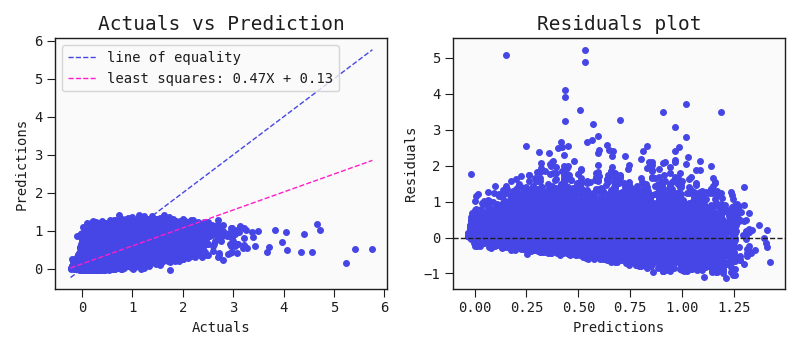

In [17]:
model_base = models[0]
model_base.plot(train)

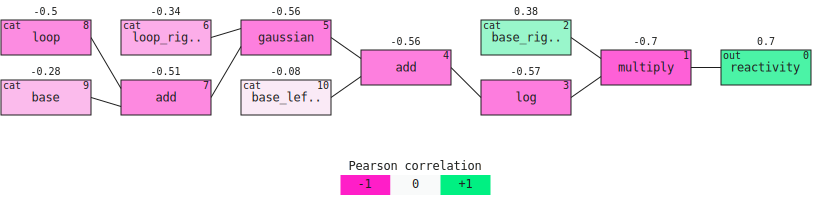

In [18]:
model_base.plot_signal(train)

CONSTRAIN THE MODEL

In [19]:
ql.reset(45)

Deprecation: The reset() function is deprecated. Instantiating a new feyn.QLattice() now achieves the same result.


In [20]:
models = ql.auto_run(train[features+[output]], output, stypes=stypes, max_complexity=2, criterion='bic')

In [21]:
model_constrained = models[0]

TRAIN AND VALIDATION SETS

The base model (unconstrained):


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="264.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 1101 264.0" width="1101" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="831" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="721" y="50.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=-1.840107
bias=-0.0022</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="766.0" y="71.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="809" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="723" y="59.0">out</text><line stroke="#1E1E1E" x1="691" x2="721" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="601" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="59.0">1</text><line stroke="#1E1E1E" x1="571" x2="601" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="571" x2="601" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="20.0"><title>base_right_motif
categorical with 16 values
bias=0.1611</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="41.5">base_rig..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="29.0">cat</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="80.0"><title>log</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="101.5">log</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="89.0">3</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="97.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">4</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="20.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">5</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>loop_right_motif
categorical with 18 values
bias=-0.3274</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" 
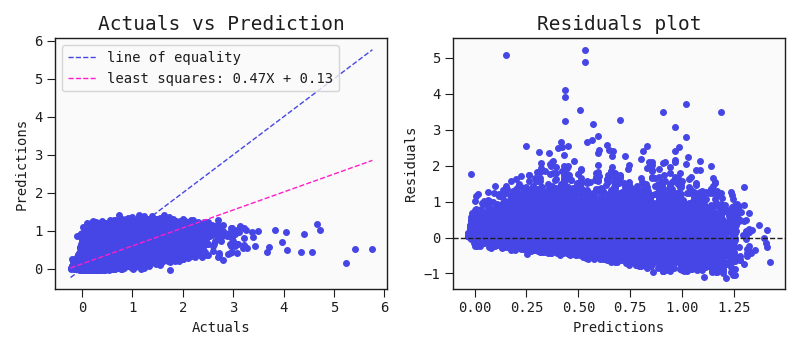
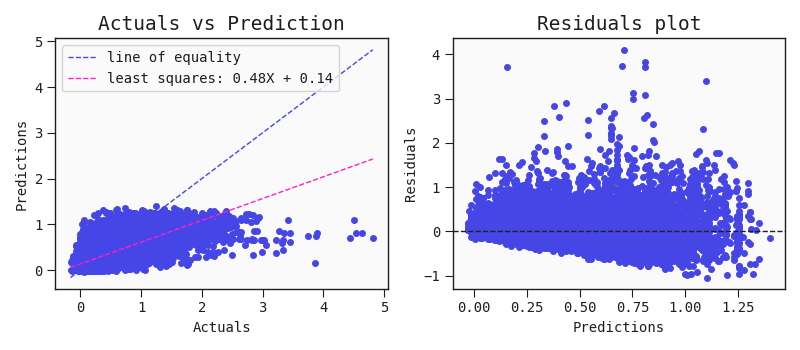

The constrained model (max complexity = 7):


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="140.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 501 140.0" width="501" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="95.0" width="231" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=-0.736918
bias=0.1787</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">out</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="37.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>loop
categorical with 7 values
bias=0.0119</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">loop</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">1</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">cat</text></svg><svg class="summary" height="64" width="180" x="231" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">R2</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.258</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">RMSE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.351</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">MAE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.238</text></svg><svg class="summary" height="64" width="90" x="411" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Test</text><line stroke="#1E1E1E" x1="0" x2="70" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="34">0.284</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="49">0.347</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="64">0.235</text></svg><svg class="h_space" height="19" width="50" x="0" y="95.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Inputs</text><line stroke="#1E1E1E" x1="0" x2="50" y1="19" y2="19" /></svg><svg class="table" height="21" width="49" x="0" y="114.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="12" text-anchor="start" x="5" y="16">loop</text></svg></svg><h4 style='font-family:monospace; margin-bottom:5px; font-weight: normal; text-decoration: underline '>Training Metrics</h4><img style='width:auto' src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAFeCAYAAAB9x3vwAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAACYY0lEQVR4nOzdd1wT9xsH8E8SQsJeCiobGSquukWrddW9sKLiqLutWsWFFqt179VqqbNatWhdrdU66uhQUas/WxcqLqaKIJuQkPH9/ZEmNSQgIyQBnvfrxUtzd/necyHc3XPfxWGMMRBCCCGEEEKIAXCNHQAhhBBCCCGk+qAEhBBCCCGEEGIwlIAQQgghhBBCDIYSEEIIIYQQQojBUAJCCCG
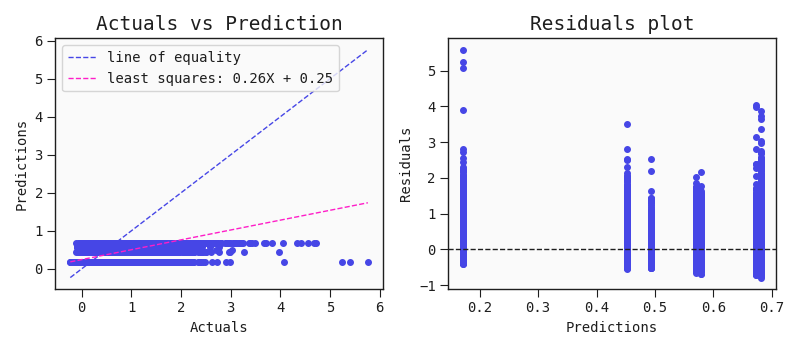
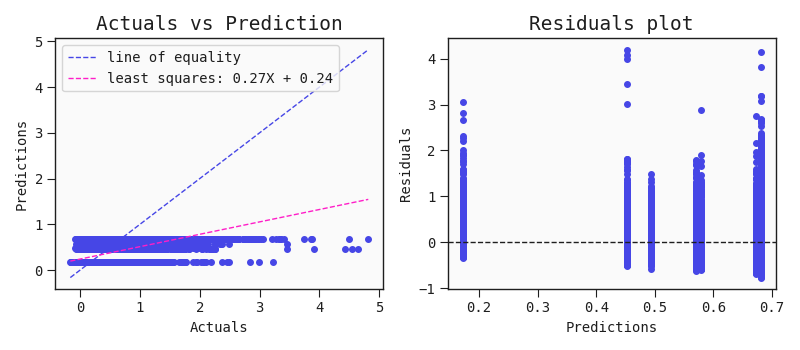

In [22]:
print('The base model (unconstrained):')
display(model_base.plot(train, valid))
print("The constrained model (max complexity = 7):")
display(model_constrained.plot(train, valid))

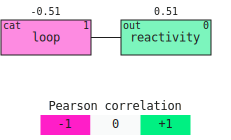

In [23]:
model_constrained.plot_signal(train)

REMOVE features which contribute least to model

In [24]:
ql.reset(42)

features = ['base', 'loop', 'base_right_motif']

Deprecation: The reset() function is deprecated. Instantiating a new feyn.QLattice() now achieves the same result.


In [25]:
models = ql.auto_run(train[features+[output]], output, stypes=stypes, max_complexity=5, criterion='bic')

In [26]:
model_three_features = models[0]

The constrained model:


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="140.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 501 140.0" width="501" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="95.0" width="231" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=-0.736918
bias=0.1787</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">out</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="37.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>loop
categorical with 7 values
bias=0.0119</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">loop</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">1</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">cat</text></svg><svg class="summary" height="64" width="180" x="231" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">R2</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.258</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">RMSE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.351</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">MAE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.238</text></svg><svg class="summary" height="64" width="90" x="411" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Test</text><line stroke="#1E1E1E" x1="0" x2="70" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="34">0.284</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="49">0.347</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="64">0.235</text></svg><svg class="h_space" height="19" width="50" x="0" y="95.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Inputs</text><line stroke="#1E1E1E" x1="0" x2="50" y1="19" y2="19" /></svg><svg class="table" height="21" width="49" x="0" y="114.0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="12" text-anchor="start" x="5" y="16">loop</text></svg></svg><h4 style='font-family:monospace; margin-bottom:5px; font-weight: normal; text-decoration: underline '>Training Metrics</h4><img style='width:auto' src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAFeCAYAAAB9x3vwAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAACYY0lEQVR4nOzdd1wT9xsH8E8SQsJeCiobGSquukWrddW9sKLiqLutWsWFFqt179VqqbNatWhdrdU66uhQUas/WxcqLqaKIJuQkPH9/ZEmNSQgIyQBnvfrxUtzd/necyHc3XPfxWGMMRBCCCGEEEKIAXCNHQAhhBBCCCGk+qAEhBBCCCGEEGIwlIAQQgghhBBCDIYSEEIIIYQQQojBUAJCCCG
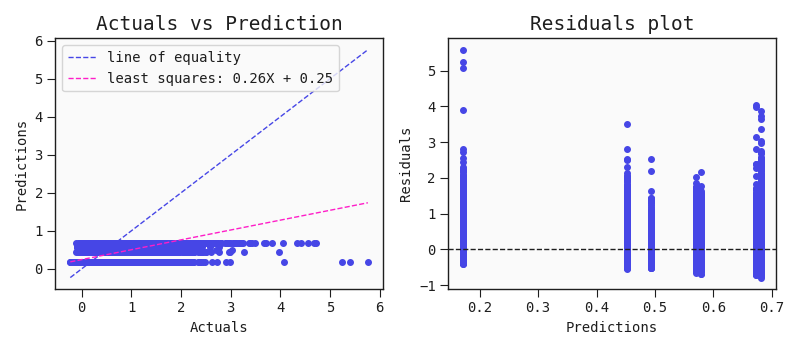
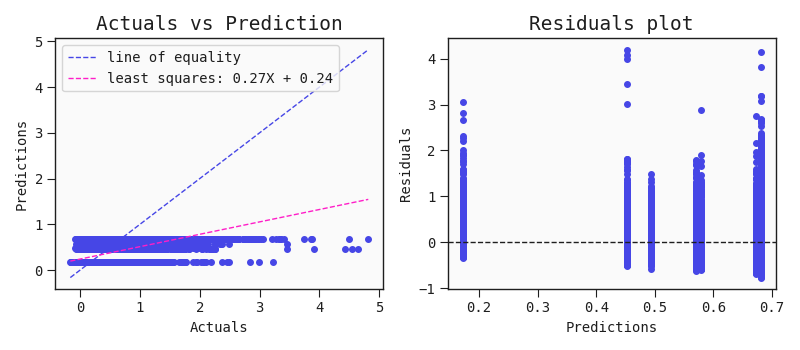

The three feature model:


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 741 232.0" width="741" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=-4.264550
bias=-0.0130</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>base_right_motif
categorical with 16 values
bias=-0.2274</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">base_rig..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">cat</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>loop
categorical with 7 values
bias=-0.3852</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">loop</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">cat</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>base
categorical with 4 values
bias=-0.4157</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">base</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">cat</text></svg><svg class="summary" height="64" width="180" x="471" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor=
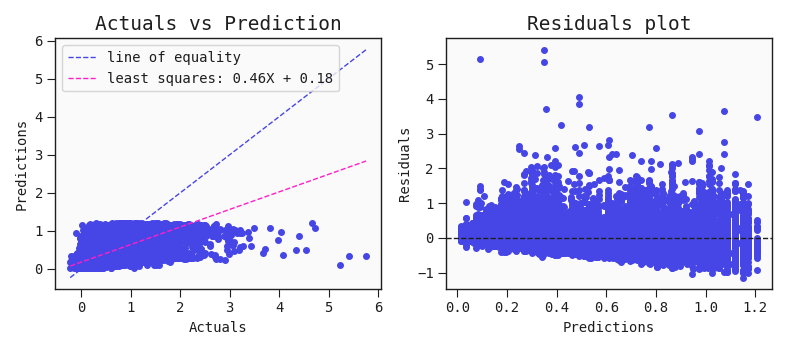
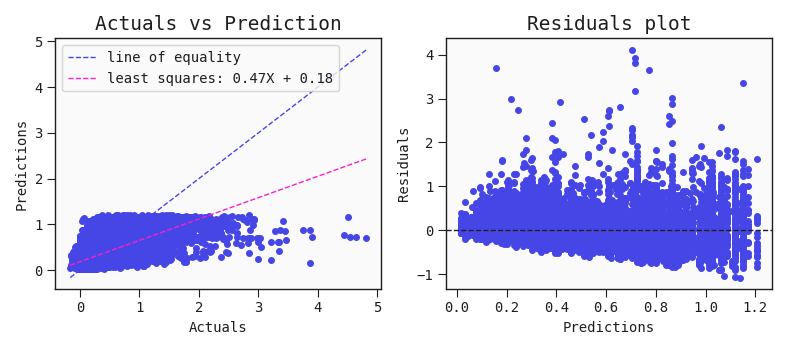

In [27]:
print('The constrained model:')
display(model_constrained.plot(train, valid))
print("The three feature model:")
display(model_three_features.plot(train, valid))

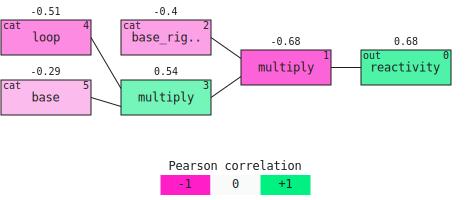

In [28]:
model_three_features.plot_signal(train)

We're very close here. It did get a little worse - but if we want to tend towards simpler, more interpretble models, the three feature model is definitely what we should go for.

It also already provides so much signal, that we can expect it to explain most of the behaviour we are able to describe using these features.

That said - we might now already also see that the base doesn't supply much information, so let's try to remove it and see how dramatic of a difference that makes.

In [29]:
ql.reset(41)

features = ['loop', 'base_right_motif']

Deprecation: The reset() function is deprecated. Instantiating a new feyn.QLattice() now achieves the same result.


In [30]:
# Note we're reducing to max complexity of 3 for two features.
models = ql.auto_run(train[features+[output]], output, stypes=stypes, max_complexity=3, criterion='bic')

In [31]:
model_two_features = models[0]

The three feature model:


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 741 232.0" width="741" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=-4.264550
bias=-0.0130</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>base_right_motif
categorical with 16 values
bias=-0.2274</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">base_rig..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">cat</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>loop
categorical with 7 values
bias=-0.3852</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">loop</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">cat</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>base
categorical with 4 values
bias=-0.4157</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">base</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">cat</text></svg><svg class="summary" height="64" width="180" x="471" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor=
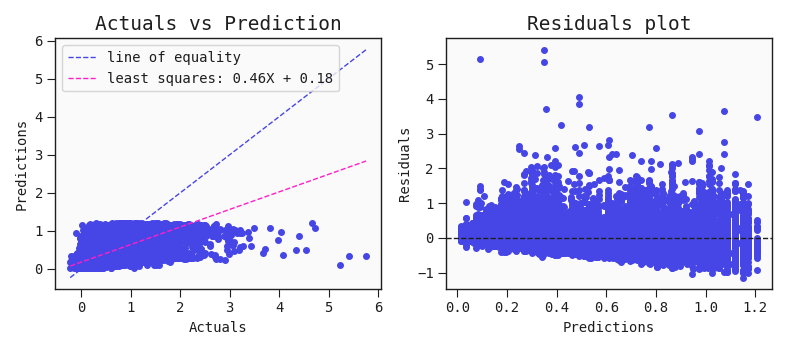
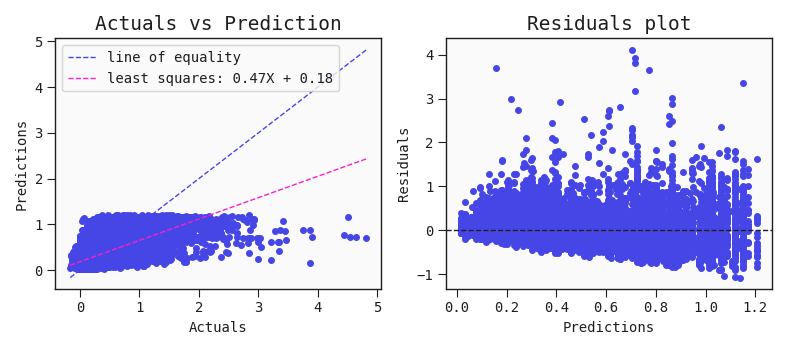

The two feature model:


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 621 216.0" width="621" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>reactivity
linear:
scale=2.993250
scale offset=0.000000
w=3.580864
bias=0.0009</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">reactivity</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>base_right_motif
categorical with 16 values
bias=-0.1690</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">base_rig..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">cat</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>loop
categorical with 7 values
bias=-0.2807</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">loop</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">cat</text></svg><svg class="summary" height="64" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">R2</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.423</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">RMSE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.309</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">MAE</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.199</text></svg><svg class="summary" height="64" width="90" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Test</text><line stroke="#1E1E1E" x1="0" x2="70" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="65" y="34">0.444</text><text fill="#1E1E1E" font-family="monospace" font-size="14"
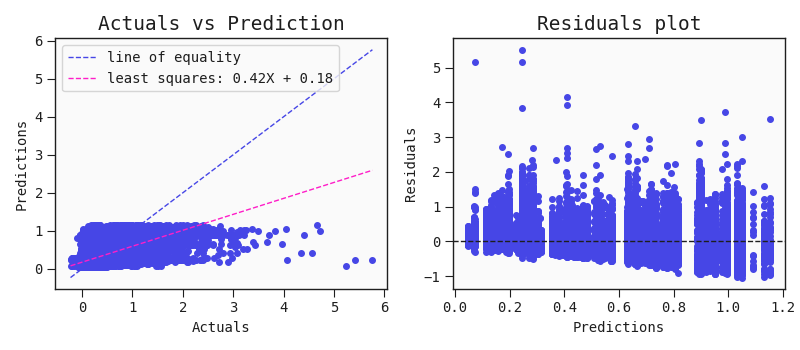
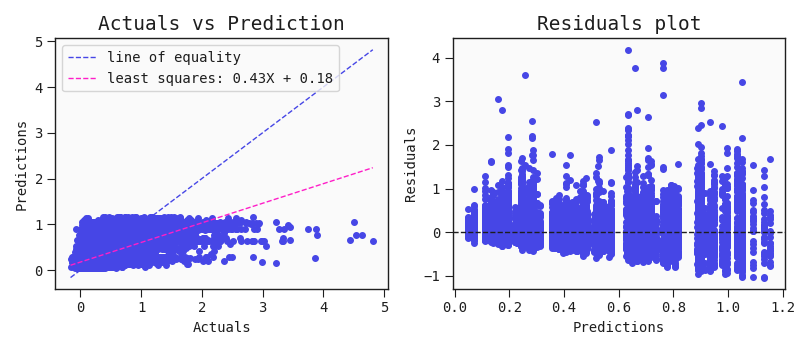

In [40]:
print("The three feature model:")
display(model_three_features.plot(train, valid))
print("The two feature model:")
display(model_two_features.plot(train, valid))

We see a bit of a drop but that's also in line with our expectations.
Still, we seem to be getting closer to the essence of the model here. The `loop` and the `base_right_motif`together.

We could reduce further down to just the loop - but without feature interactions it's fairly obvious that the performance would reduce to just the explanative power of the loop feature.

##### model_two_features.plot_signal(train)

### PLOTTING

In [33]:
def plot_RNA_seq(model, data, idx, figsize = (24,5), grid=True, title=''):
    
    output = model.output    
    fig, ax = plt.subplots(figsize = figsize)        
    
    sub_seq = data.query(f'RNA_idx == {idx}')

    prediction = model.predict(sub_seq)
    ax.plot(range(len(sub_seq)), sub_seq[output], label = 'actuals')
    ax.plot(range(len(sub_seq)), prediction, label = 'pred')

    x_axis1 = list(sub_seq['loop'].values)
    x_axis2 = list(sub_seq['base'].values)

    x_axis = list(zip(x_axis1, x_axis2))
    x_axis = ["_".join(x_axis[i]) for i in range(len(x_axis))]

    ax.set_xticks(range(len(sub_seq)))
    ax.set_xticklabels(x_axis)
    ax.tick_params(rotation = 90)
    ax.set_title(title+str(idx))

    ax.set_ylabel(output)
    ax.set_xlabel('sequence (loop and base)')

    ax.legend()

    if grid:
        ax.grid()

    return ax

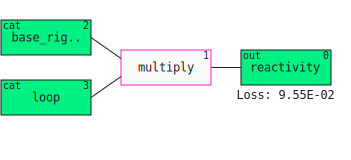

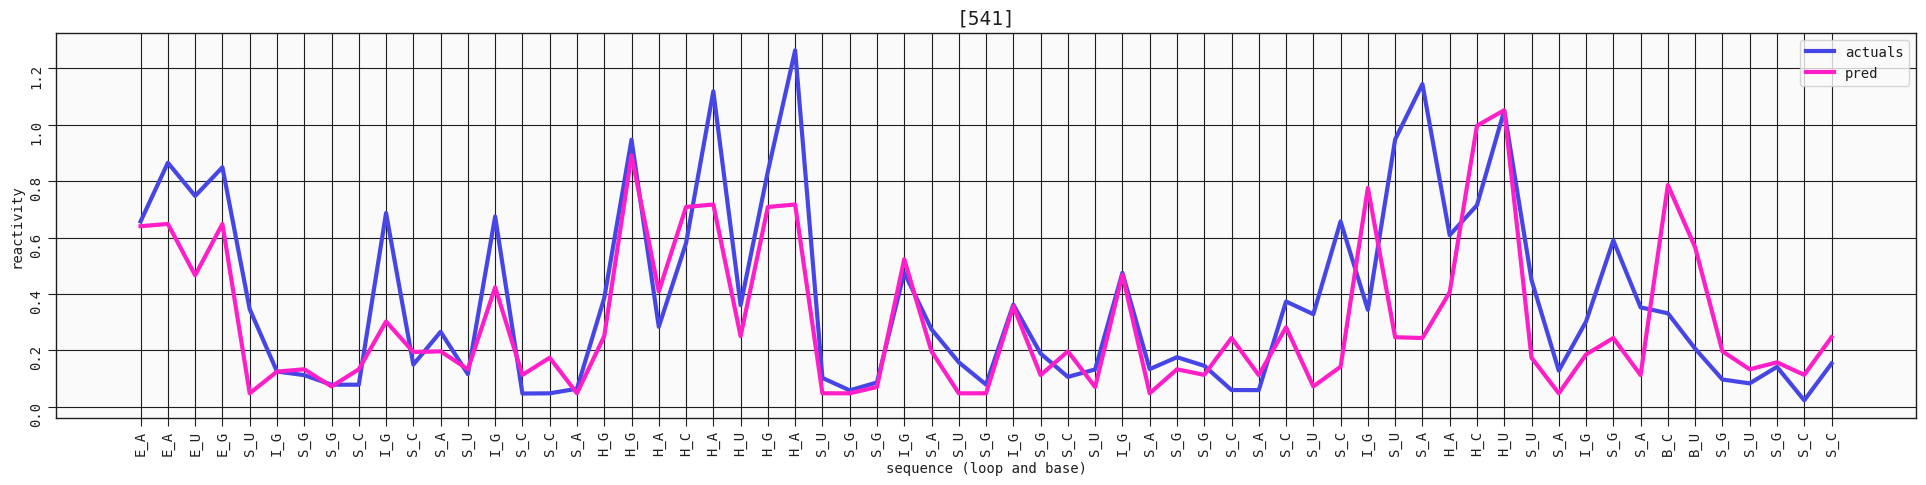

In [34]:
plot_RNA_seq(model_two_features, valid, [541])
display(model_two_features)

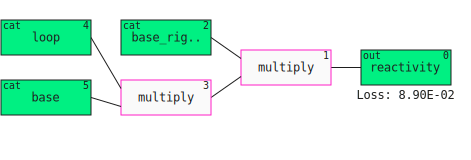

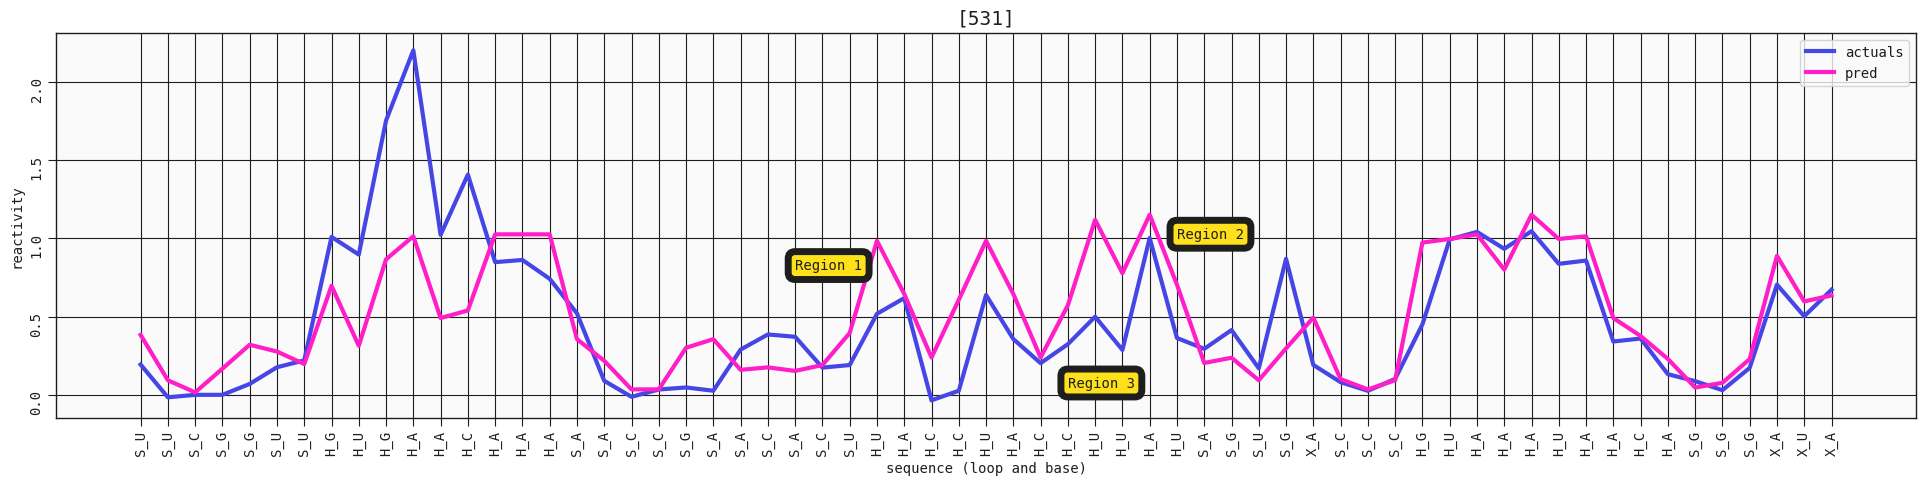

In [43]:
ax = plot_RNA_seq(model_three_features, valid, [531])
ax.annotate('Region 1', (24,0.8), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE11B', lw=5))
ax.annotate('Region 2', (38,1), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE11B', lw=5))
ax.annotate('Region 3', (34,0.05), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE11B', lw=5))
display(model_three_features)

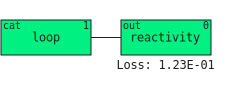

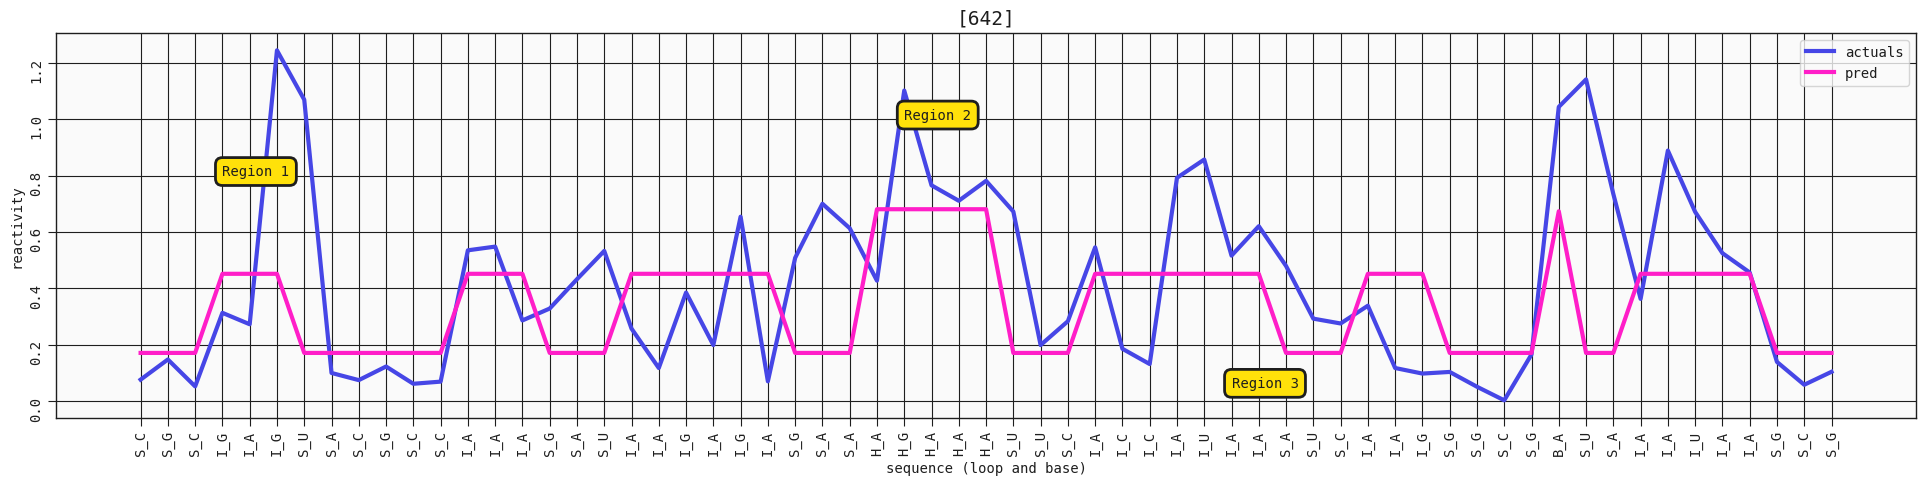

In [36]:
ax = plot_RNA_seq(model_constrained, valid, [642])
ax.annotate('Region 1', (3,0.8), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE10A', lw=2))
ax.annotate('Region 2', (28,1), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE10A', lw=2))
ax.annotate('Region 3', (40,0.05), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE10A', lw=2))
display(model_constrained)

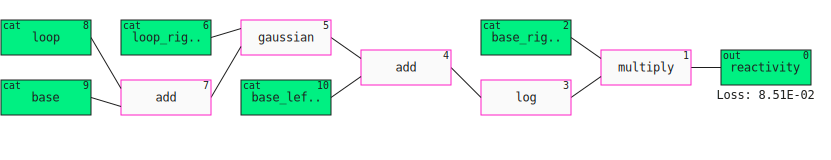

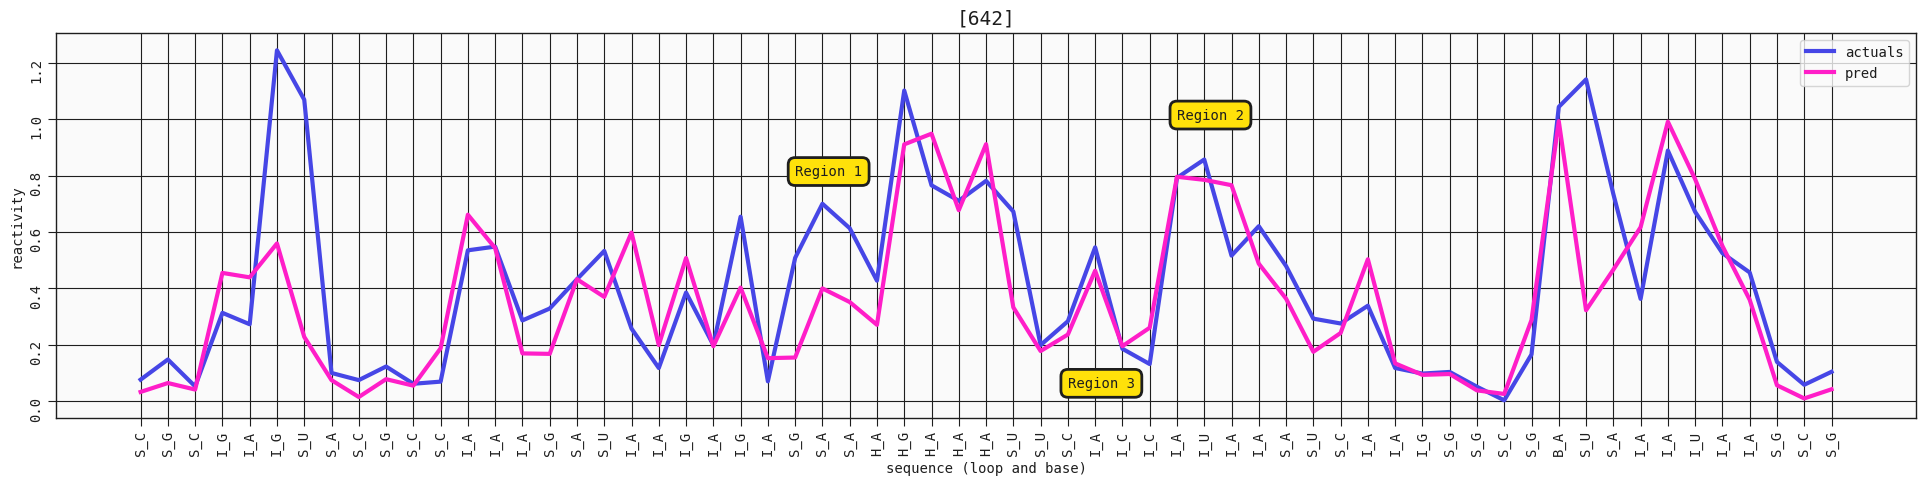

In [37]:
ax = plot_RNA_seq(model_base, valid, [642])
ax.annotate('Region 1', (24,0.8), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE10A', lw=2))
ax.annotate('Region 2', (38,1), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE10A', lw=2))
ax.annotate('Region 3', (34,0.05), bbox=dict(boxstyle="round,pad=0.5", fc='#FFE10A', lw=2))
display(model_base)

## RMSE from complex to simple model

In [38]:
print(f'RMSE model features: {len(model_base.features)}: {model_base.rmse(valid):.4f}')
print(f'RMSE model features: {len(model_constrained.features)}: {model_constrained.rmse(valid):.4f}')
print(f'RMSE model features: {len(model_three_features.features)}: {model_three_features.rmse(valid):.4f}')
print(f'RMSE model features: {len(model_two_features.features)}: {model_two_features.rmse(valid):.4f}')

RMSE model features: 5: 0.2923
RMSE model features: 1: 0.3474
RMSE model features: 3: 0.2965
RMSE model features: 2: 0.3061


## holdout sets

In [39]:
print(f'RMSE model features: {len(model_base.features)}: {model_base.rmse(holdout):.4f}')
print(f'RMSE model features: {len(model_constrained.features)}: {model_constrained.rmse(holdout):.4f}')
print(f'RMSE model features: {len(model_three_features.features)}: {model_three_features.rmse(holdout):.4f}')
print(f'RMSE model features: {len(model_two_features.features)}: {model_two_features.rmse(holdout):.4f}')

RMSE model features: 5: 0.2932
RMSE model features: 1: 0.3492
RMSE model features: 3: 0.2968
RMSE model features: 2: 0.3075


## CREDIT :ABZU team; Keggle (https://www.kaggle.com/c/stanford-covid-vaccine)